# Customer Data Analysis and Product Revenue Prediction with ARIMA and Deep Learning   


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Source](#data)
* [Methodology](#methodology)
* [Exploratory Data Analysis](#analysis)
* [Time Series Analysis and Forecasting with ARIMA](#time)
* [Time Series Forecasting with Deep Learning](#machine) 


## Part 1. Introdiction: Business Problem<a name="introduction"></a>

AAVAIL is a video service company similar to NETFLIX. To increase the competitiveness, AAVAIL launched a tiered, subscription-based service which had showed promise in USA. Therefore, the experiment testing the new approach was carried out outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue.

The aim of this project is first to do the customer data analysis on the current database and then build a model that, at any point in time, to predict the revenue for the following month especially for the top ten countries with the most revenue. In addition, for easy applying by other team with less IT skills like the marketing team, the management needs a API to automate the whole process, from extracting relevant data from multiple data sources to model deployment for revenue prediction.





## Part 2. Data Source<a name="data"></a>
The data for this case study comes from the online retail data set and are available through the UCI Machine Learning Repository. The original data were published as a study that used RFM model to explore customer segmentation in the data set. The data presented in this study are derived from this data set with simulated features and re-named columns to align with the AAVAIL case study. The datasets are a couple of jason files with details of the transaction from the customer since 2017

In [1]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2.1 Import Data

In [0]:
data_dir='/content/drive/My Drive/Colab Notebooks/IBM AI-workflow-capstone-master/cs-train'
file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]

## read data into a temp structure
all_months = {}
for file_name in file_list:
    df = pd.read_json(file_name)
    all_months[os.path.split(file_name)[-1]] = df

In [3]:
all_months

{'invoices-2017-11.json':              country  customer_id invoice  ...  year month  day
 0     United Kingdom      13085.0  489434  ...  2017    11   28
 1     United Kingdom          NaN  489597  ...  2017    11   28
 2     United Kingdom          NaN  489597  ...  2017    11   28
 3     United Kingdom          NaN  489597  ...  2017    11   28
 4     United Kingdom          NaN  489597  ...  2017    11   28
 ...              ...          ...     ...  ...   ...   ...  ...
 9497  United Kingdom      13895.0  490052  ...  2017    11   30
 9498  United Kingdom      16779.0  490048  ...  2017    11   30
 9499  United Kingdom      13895.0  490052  ...  2017    11   30
 9500  United Kingdom      13895.0  490052  ...  2017    11   30
 9501  United Kingdom      13895.0  490052  ...  2017    11   30
 
 [9502 rows x 9 columns],
 'invoices-2017-12.json':               country  customer_id invoice  ...  year month  day
 0      United Kingdom      13162.0  490297  ...  2017    12    1
 1      Un

In [4]:
df = pd.concat(list(all_months.values()))
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,StreamID,TimesViewed,total_price
0,United Kingdom,17841.0,555562,1.95,22659,1.0,2019,6,2,NaN,NaN,NaN
1,United Kingdom,17841.0,555562,0.55,21975,5.0,2019,6,2,NaN,NaN,NaN
2,United Kingdom,17841.0,555562,0.83,23182,1.0,2019,6,2,NaN,NaN,NaN
3,United Kingdom,17841.0,555562,1.65,22136,1.0,2019,6,2,NaN,NaN,NaN
4,United Kingdom,17841.0,555562,2.95,22807,2.0,2019,6,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
33178,United Kingdom,16119.0,506696,1.95,NaN,NaN,2018,4,29,79029,6.0,NaN
33179,United Kingdom,17675.0,506697,1.69,NaN,NaN,2018,4,29,21242,8.0,NaN
33180,United Kingdom,17675.0,506697,1.25,NaN,NaN,2018,4,29,20677,8.0,NaN
33181,United Kingdom,17675.0,506697,1.25,NaN,NaN,2018,4,29,20675,8.0,NaN



### 2.2 Quality Assurance step

In order to make sure that the data passes quality control check, a few tests are created in order to check the column name for consistency because otherwise it would not be possible to create a unified dataframe and do further analysis. The data also needs to be sorted in a chronological order to carry out a predictive or forecasting analysis.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815011 entries, 0 to 33182
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   country       815011 non-null  object 
 1   customer_id   625249 non-null  float64
 2   invoice       815011 non-null  object 
 3   price         654316 non-null  float64
 4   stream_id     292297 non-null  object 
 5   times_viewed  292297 non-null  float64
 6   year          815011 non-null  int64  
 7   month         815011 non-null  int64  
 8   day           815011 non-null  int64  
 9   StreamID      522714 non-null  object 
 10  TimesViewed   522714 non-null  float64
 11  total_price   160695 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 80.8+ MB


In [6]:
df.isnull().sum()

country              0
customer_id     189762
invoice              0
price           160695
stream_id       522714
times_viewed    522714
year                 0
month                0
day                  0
StreamID        292297
TimesViewed     292297
total_price     654316
dtype: int64

In [7]:
df.StreamID

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
33178    79029
33179    21242
33180    20677
33181    20675
33182    20676
Name: StreamID, Length: 815011, dtype: object

In [8]:
df.stream_id.fillna(df.StreamID,inplace=True)
df.times_viewed.fillna(df.TimesViewed,inplace=True)
df.price.fillna(df.total_price,inplace=True)
df.drop(['StreamID','TimesViewed','total_price'],axis=1,inplace=True)
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
0,United Kingdom,17841.0,555562,1.95,22659,1.0,2019,6,2
1,United Kingdom,17841.0,555562,0.55,21975,5.0,2019,6,2
2,United Kingdom,17841.0,555562,0.83,23182,1.0,2019,6,2
3,United Kingdom,17841.0,555562,1.65,22136,1.0,2019,6,2
4,United Kingdom,17841.0,555562,2.95,22807,2.0,2019,6,2
...,...,...,...,...,...,...,...,...,...
33178,United Kingdom,16119.0,506696,1.95,79029,6.0,2018,4,29
33179,United Kingdom,17675.0,506697,1.69,21242,8.0,2018,4,29
33180,United Kingdom,17675.0,506697,1.25,20677,8.0,2018,4,29
33181,United Kingdom,17675.0,506697,1.25,20675,8.0,2018,4,29


In [0]:
df['invoice_date']=(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)).astype('datetime64')

In [10]:
df.sort_values('invoice_date',inplace=True)
df.reset_index(drop=True,inplace=True)
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
0,United Kingdom,NaN,489609,4.00,M,1.0,2017,11,28,2017-11-28
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815006,United Kingdom,16098.0,562271,3.75,22730,4.0,2019,7,31,2019-07-31
815007,United Kingdom,16098.0,562271,3.75,22725,2.0,2019,7,31,2019-07-31
815008,United Kingdom,16098.0,562271,3.75,22726,12.0,2019,7,31,2019-07-31
815009,United Kingdom,14056.0,562269,1.65,22558,3.0,2019,7,31,2019-07-31


In [11]:
df.price.describe()

count    815011.000000
mean          4.802631
std         135.058707
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       38970.000000
Name: price, dtype: float64

In [12]:
df=df.query('price>0')
df.dropna(inplace=True)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
5,United Kingdom,13085.0,489434,1.25,21871,14.0,2017,11,28,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815005,United Kingdom,16098.0,562271,9.95,23316,1.0,2019,7,31,2019-07-31
815006,United Kingdom,16098.0,562271,3.75,22730,4.0,2019,7,31,2019-07-31
815007,United Kingdom,16098.0,562271,3.75,22725,2.0,2019,7,31,2019-07-31
815008,United Kingdom,16098.0,562271,3.75,22726,12.0,2019,7,31,2019-07-31


## Part 3. Methodology <a name="methodology"></a>

We will need to state the ideal data to address the business opportunity and clarify the rationale for needing specific data.
The ideal data would contain a feature set based on which the revenue of the AAVAIL could be predicted such as the number of subscribers, types of subscription, location etc and the target variable would be the revenue. This will help in building a supervised learning pipeline which would be predicting the target variable "Revenue" based on the feature set or dependent variables.

An alternative scenario would be the application of time-series analysis where the revenue of AAVAIL is given alongwith the timestamp. Thus, a timeseries forecasting technique could be applied to obtain the budget projection based on the historical data.

First, the explortory analysis will be conducted to reveal the general information:
* Assimilate the business scenario and articulate testable hypotheses.
* State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
* Investigate the relationship between the relevant data, the target and the business metric.
* Articulate your findings using a deliverable with visualizations. 
* Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.


Second step in our analysis will focus on modelling:
* State the different modeling approaches that you will compare to address the business opportunity.
* Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
* Re-train your model on all of the data using the selected approach and prepare it for deployment.


## Part 4. Exploratory Data Analysis<a name="analysis"></a>

Investigate the relationship between the relevant data, the target and the business metric

####4.1 Top 10 Countries in terms of revenue

In [13]:
table=pd.pivot_table(data=df,index='country',values='price',aggfunc='sum')
table.columns=['Total Revenue']
table.sort_values('Total Revenue',inplace=True)
table=table.tail(10)
top_countries=table.index
table

,Total Revenue
country,
Belgium,1.119061e+04
Netherlands,1.232280e+04
Singapore,1.317592e+04
Portugal,1.328929e+04
Spain,1.604099e+04
Norway,3.849475e+04
France,4.039552e+04
Germany,4.927182e+04
EIRE,9.243843e+04


**Selecting only top 10 countries for further analysis**

In [14]:
top_countries=table.index.to_list()
top_countries

['Belgium',
 'Netherlands',
 'Singapore',
 'Portugal',
 'Spain',
 'Norway',
 'France',
 'Germany',
 'EIRE',
 'United Kingdom']

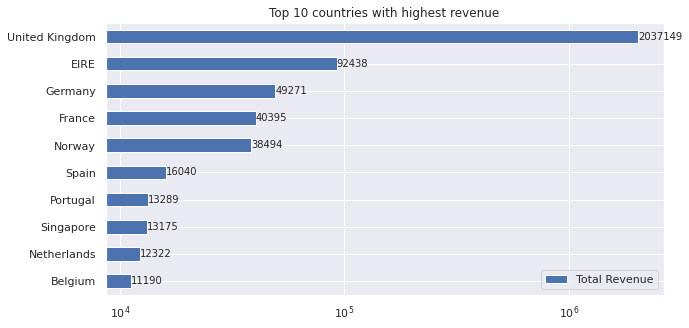

In [15]:
table.plot.barh(figsize=(10,5))
plt.title('Top 10 countries with highest revenue')
plt.xscale('log')
plt.xlabel('')
plt.ylabel('')
for i,index in enumerate(list(table.index)):
  label=(table.loc[index,'Total Revenue']).astype(int)
  plt.annotate(label,(label,i-0.1))


**Revenue changes of top 10 countries**

In [16]:
table=pd.pivot_table(data=df[df.country.isin(top_countries)],index='country',columns='year',values='price',aggfunc='sum')
table.head()

year,2017,2018,2019
country,,,
Belgium,209.10,7291.000,3690.51
EIRE,4007.22,69216.620,19214.59
France,1200.34,24411.120,14784.06
Germany,1525.79,30554.331,17191.70
Netherlands,384.26,8948.110,2990.43


Text(0.5, 1.0, 'Revenue changes of Top 10 countries')

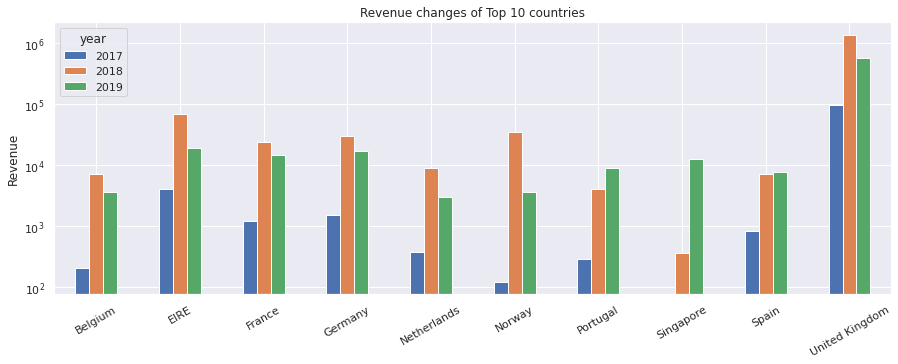

In [17]:
table.plot.bar(figsize=(15,5))
plt.yscale('log')
plt.xlabel('')
plt.xticks(rotation=30)
plt.ylabel('Revenue')
plt.title('Revenue changes of Top 10 countries')

* It is clear that the revenue from almost all top 10 countries declined since 2018 except for Portugal, Singapore and Spain. Then which countries' revenue has rised?


####4.2 Countries where the revenue has incresed since 2018

In [0]:
countries_2019=df.query('year==2019').country.to_list()
countries_2018=df.query('year==2018').country.to_list()
df_2019=df[df.country.isin(countries_2019) & df.country.isin(countries_2018)]

In [19]:
df_diff=pd.pivot_table(data=df_2019.query('year!=2017'),index=(['year','country']),values='price',aggfunc='sum')
df_diff.columns=['Total_Revenue']
df_diff

Total_Revenue
year country                            
2018 Australia                  4140.330
     Austria                    2356.520
     Bahrain                      91.560
     Belgium                    7291.000
     Brazil                      113.710
...                                  ...
2019 Switzerland                3793.330
     USA                          74.200
     United Arab Emirates         77.570
     United Kingdom           573384.352
     Unspecified                 634.490

[62 rows x 1 columns]

In [20]:
df_diff.reset_index().country.nunique()

31

In [21]:
df_diff.reset_index(inplace=True)
df_diff

,year,country,Total_Revenue
0,2018,Australia,4140.330
1,2018,Austria,2356.520
2,2018,Bahrain,91.560
3,2018,Belgium,7291.000
4,2018,Brazil,113.710
...,...,...,...
57,2019,Switzerland,3793.330
58,2019,USA,74.200
59,2019,United Arab Emirates,77.570
60,2019,United Kingdom,573384.352


In [0]:
list_reve_diff=df_diff.Total_Revenue.pct_change(periods=31)[31:]
list_country=df_diff.country.unique()

In [23]:
d = {'country': list_country , 'diff': list_reve_diff}
df_diff = pd.DataFrame(data=d)
df_diff=df_diff.query('diff>0').sort_values('diff')
df_diff.set_index(['country'],inplace=True)
df_diff

,diff
country,
Iceland,0.018928
Spain,0.078321
Brazil,0.254067
Finland,0.290929
Cyprus,0.374995
Poland,0.960242
Portugal,1.206347
Canada,5.139177
Singapore,33.370648


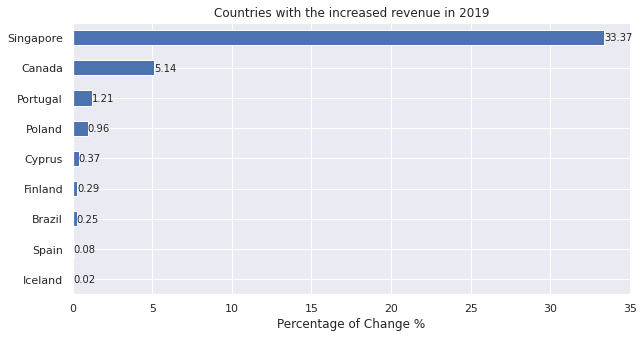

In [24]:
df_diff.plot.barh(figsize=(10,5))
plt.title('Countries with the increased revenue in 2019')
plt.xlabel('Percentage of Change %')
plt.ylabel('')
plt.legend().remove()
for i,index in enumerate(list(df_diff.index)):
  label=round((df_diff.loc[index,'diff']),2)
  plt.annotate(label,(label,i-0.1))


* It is clear that the revenue in 9 countries has increased since 2018 and three of them are among the top 10 countries with the highest revenue which are Portugal, Singapore and Spain

**Reason why the revenue has increased**

Text(0.5, 1.0, 'Days with purchase')

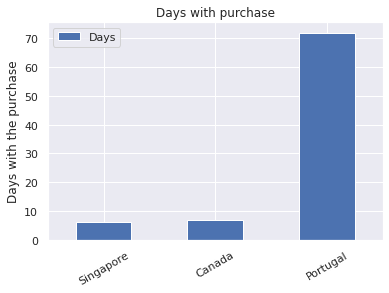

In [25]:
df_days_purchase=pd.DataFrame({'Country':['Singapore','Canada','Portugal'],
                               'Days':[df.query("country=='Singapore'").invoice_date.nunique(),
                                       df.query("country=='Canada'").invoice_date.nunique(),
                                       df.query("country=='Portugal'").invoice_date.nunique()]})
df_days_purchase.set_index('Country',inplace=True)
df_days_purchase.plot.bar()
plt.xlabel('')
plt.ylabel('Days with the purchase')
plt.xticks(rotation=30)
plt.title('Days with purchase')

The reasons why the countreis revenue increas is because there is not enough purchase in these countries. 

####4.3 The price change of the top 10 popular streams 

In [26]:
df.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
5,United Kingdom,13085.0,489434,1.25,21871,14.0,2017,11,28,2017-11-28


In [27]:
#Top 10 popular streams around the world
df_t10_st_w=df.groupby('stream_id')['times_viewed'].sum().reset_index().sort_values('times_viewed',ascending=False).head(10).reset_index(drop=True)
list_t10_st_w=df_t10_st_w.stream_id.to_list()
df_t10_st_w

,stream_id,times_viewed
0,85123A,33702.0
1,85099B,22700.0
2,84879,21239.0
3,21212,20733.0
4,20725,16974.0
5,21232,16372.0
6,84991,13455.0
7,22423,13320.0
8,21080,12395.0
9,22178,12215.0


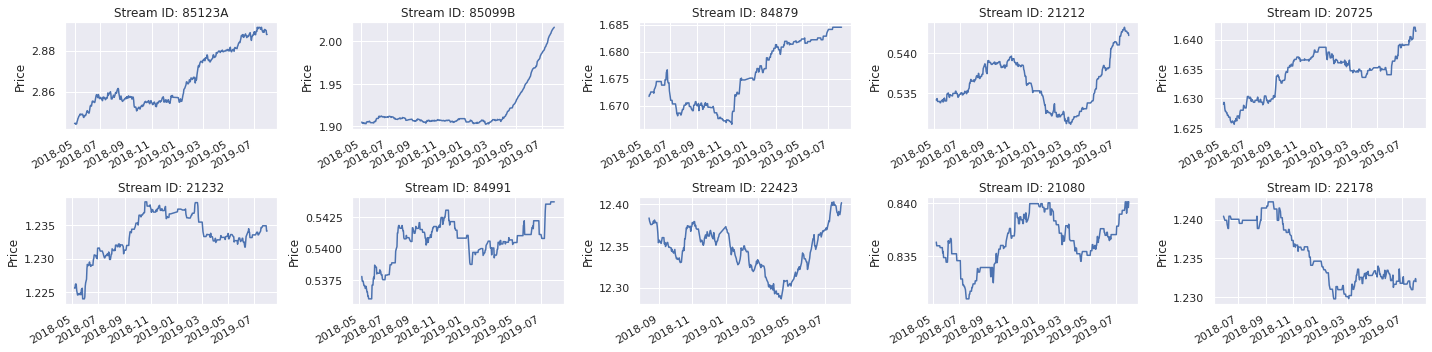

In [28]:
#Price changes during 2019
fig,ax=plt.subplots(2,5,figsize=(20,5))
for i in range(5):
  df[df.stream_id==list_t10_st_w[i]][['price','invoice_date']].groupby('invoice_date')['price'].mean().rolling(window=120).mean().plot(ax=ax[0][i])
  ax[0][i].set_title("Stream ID: "+list_t10_st_w[i])
  ax[0][i].set_xlabel('')
  ax[0][i].set_ylabel('Price')

for i in range(5,10):
  df[df.stream_id==list_t10_st_w[i]][['price','invoice_date']].groupby('invoice_date')['price'].mean().rolling(window=120).mean().plot(ax=ax[1][i-5])
  ax[1][i-5].set_title("Stream ID: "+list_t10_st_w[i])
  ax[1][i-5].set_xlabel('')
  ax[1][i-5].set_ylabel('Price')
plt.tight_layout()


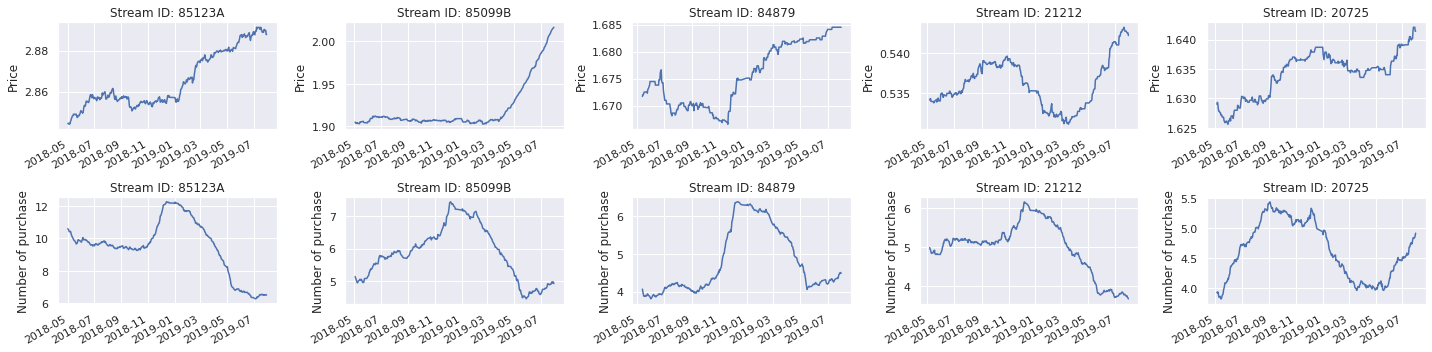

In [29]:
#Price changes during 2019
fig,ax=plt.subplots(2,5,figsize=(20,5))
for i in range(5):
  df[df.stream_id==list_t10_st_w[i]][['price','invoice_date']].groupby('invoice_date')['price'].mean().rolling(window=120).mean().plot(ax=ax[0][i])

  ax[0][i].set_title("Stream ID: "+list_t10_st_w[i])
  ax[0][i].set_xlabel('')
  ax[0][i].set_ylabel('Price')

for i in range(5,10):
  df[df.stream_id==list_t10_st_w[i-5]][['price','invoice_date']].groupby('invoice_date')['price'].count().rolling(window=120).mean().plot(ax=ax[1][i-5])
  ax[1][i-5].set_title("Stream ID: "+list_t10_st_w[i-5])
  ax[1][i-5].set_xlabel('')
  ax[1][i-5].set_ylabel('Number of purchase')
  
plt.tight_layout()

* It is clear that the price of majority of the streams is increased during the year 2019. It indicates that the increased price may be one of the factors for the purchase reduction. More details need to be obtained regarding the genres of the stream. The marketing team could recommend or advertise the popular genres to the target countries.

##Part 5. Time Series Analysis and Forecasting with ARIMA<a name="time"></a>

### 5.1 Time Series forecasting data preparation
In order to carry out a time series analysis, record of each day should be considered and the dataframe should be in a chronological order so that forecasting models can fit and provide revenue i.e price for the following month. Let's start by aggregating the transactions by day

**Time series by day**

In [0]:
# Creat function to generate time series information
def convert_to_ts(df_orig, country=None):
    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
       
    df_time = df.groupby('invoice_date').agg({'customer_id': 'nunique',
                                              'invoice': 'nunique',
                                              'stream_id': 'nunique',
                                              'times_viewed':'sum', 
                                              'price':'sum'}).reset_index()
    df_time.columns=['date','num_customer','num_invoices','num_streams','total_views','revenue']
    df_time['weekday'] = df_time['date'].dt.weekday     
    df_time['month']=df_time['date'].astype(str).str[-5:-3]
    df_time['year_month']=df_time['date'].astype(str).str[:-3]
    return(df_time)


In [31]:
df_time_day=convert_to_ts(df)
df_time_day

,date,num_customer,num_invoices,num_streams,total_views,revenue,weekday,month,year_month
0,2017-11-28,117,137,1063,13285.0,7541.01,1,11,2017-11
1,2017-11-29,98,120,1090,12111.0,6982.95,2,11,2017-11
2,2017-11-30,116,137,1093,14541.0,9214.00,3,11,2017-11
3,2017-12-01,82,93,1009,11319.0,5573.63,4,12,2017-12
4,2017-12-02,26,30,285,3310.0,1443.26,5,12,2017-12
...,...,...,...,...,...,...,...,...,...
490,2019-07-26,60,66,594,7145.0,2708.28,4,07,2019-07
491,2019-07-28,37,42,784,6989.0,3092.25,6,07,2019-07
492,2019-07-29,38,42,654,6609.0,3460.66,0,07,2019-07
493,2019-07-30,53,56,664,7384.0,2781.47,1,07,2019-07


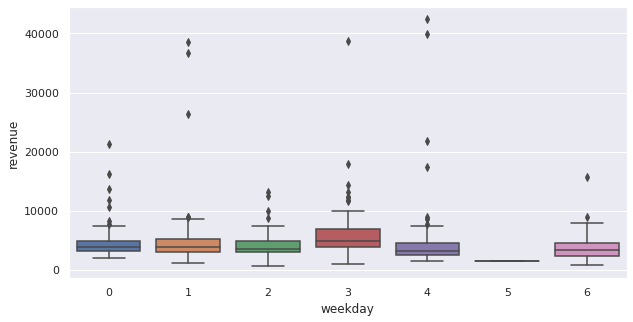

In [32]:
plt.figure(figsize=(10,5))
sns.boxplot(x="weekday", y="revenue", data=df_time_day)

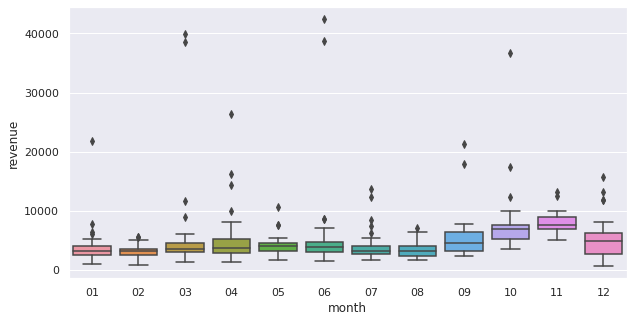

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y="revenue", data=df_time_day)

It is clear that the revenue on Wednesday is higher among the week. Besides, there are outliers that could affect the forecasting which need to removed.

In [34]:
#remove outliers
df_time_day=df_time_day.query('revenue<12000')
df_time_day

,date,num_customer,num_invoices,num_streams,total_views,revenue,weekday,month,year_month
0,2017-11-28,117,137,1063,13285.0,7541.01,1,11,2017-11
1,2017-11-29,98,120,1090,12111.0,6982.95,2,11,2017-11
2,2017-11-30,116,137,1093,14541.0,9214.00,3,11,2017-11
3,2017-12-01,82,93,1009,11319.0,5573.63,4,12,2017-12
4,2017-12-02,26,30,285,3310.0,1443.26,5,12,2017-12
...,...,...,...,...,...,...,...,...,...
490,2019-07-26,60,66,594,7145.0,2708.28,4,07,2019-07
491,2019-07-28,37,42,784,6989.0,3092.25,6,07,2019-07
492,2019-07-29,38,42,654,6609.0,3460.66,0,07,2019-07
493,2019-07-30,53,56,664,7384.0,2781.47,1,07,2019-07


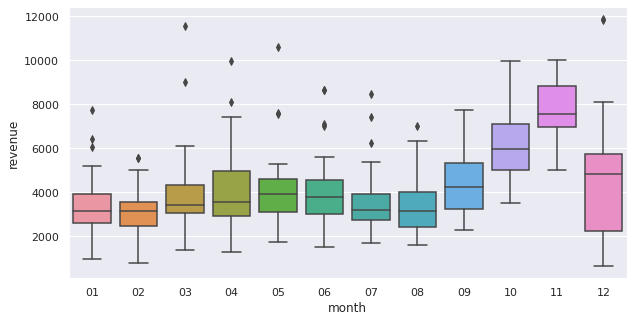

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y="revenue", data=df_time_day)

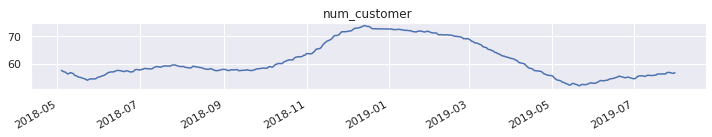

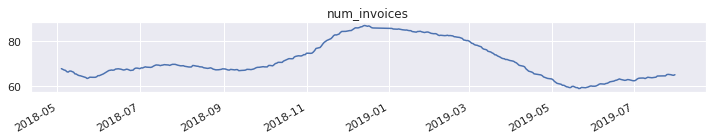

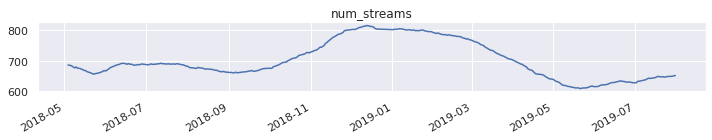

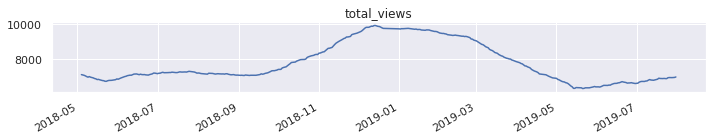

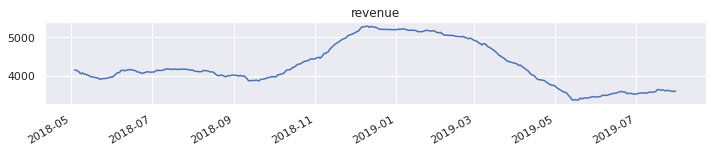

In [36]:
col_all=['num_customer','num_invoices','num_streams','total_views','revenue']
df_time_day.set_index('date',inplace=True)
for i, col in enumerate(col_all):
  plt.figure(figsize=(10,8))
  plt.subplot(5,1,i+1)
  df_time_day[col].rolling(window=120).mean().plot(x='date')
  plt.title(col)
  plt.xlabel('')
  plt.tight_layout()

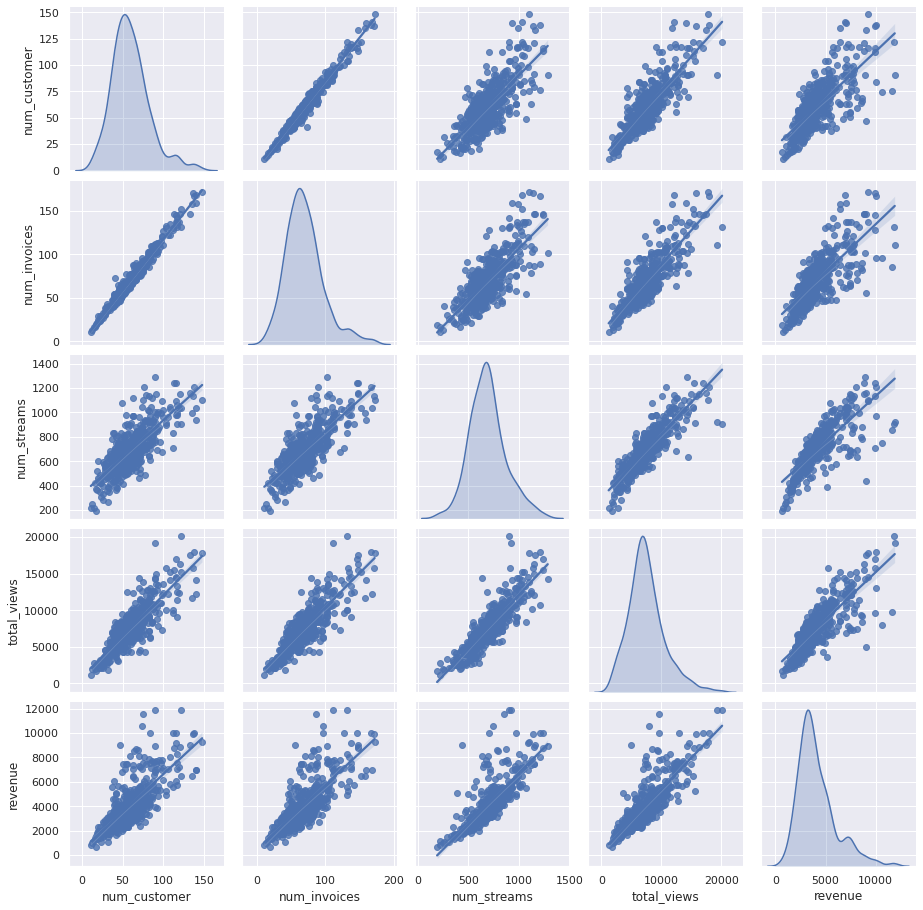

In [37]:
sns.pairplot(data=df_time_day, 
             vars=col_all,
             kind='reg',
             diag_kind='kde')

* It is clear that the all features reached the peak in January 2019 then gradually declined. All features are also positively related


Now the data has been arranged in the chronological order, so it can be used in time-series forecasting model in order to project revenue for the following month. Given dataframe in this form, forecasted results would produce the price or "revenue" for each day based on the features provided to the model. In order to gain monthly revenue, we need to aggregate the data by month rather than day.

**Time series by month**

In [38]:
df_time_month = df_time_day.groupby('year_month').agg({'total_views':'sum', 'revenue':'sum'})#.reset_index()
#df_time_month.set_index('month')
df_time_month.head()

,total_views,revenue
year_month,,
2017-11,39937.0,23737.960
2017-12,143131.0,82787.340
2018-01,149760.0,95138.983
2018-02,147283.0,81389.164
2018-03,172581.0,98119.171


The deliverables here are the dataframes 'df_time_month' and 'df_time_day' that can be used for forecasting monthly and daily revenue respectively

### 5.2 Stationarity check of a time-series

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test. If the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. 

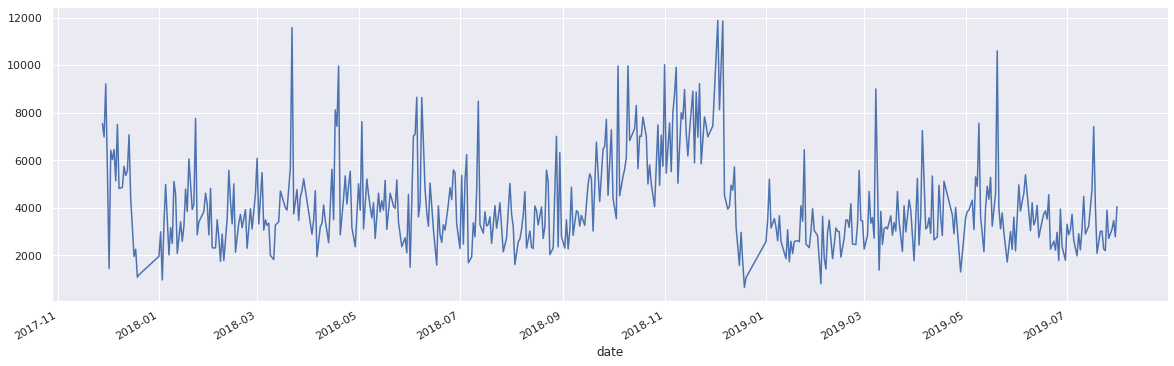

In [39]:
# checking stationarity of a time-series on a daily basis
ts_day= df_time_day['revenue']
ts_day.plot(figsize=(20, 6))

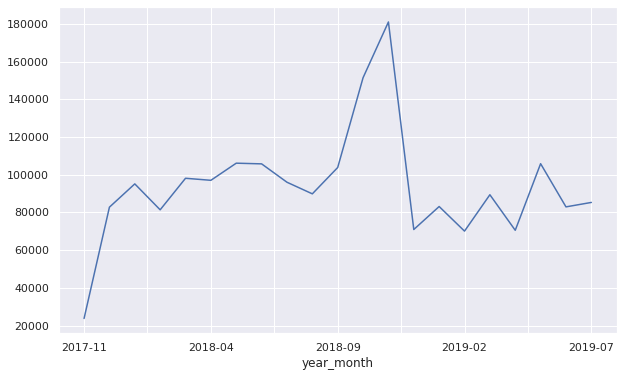

In [40]:
# checking stationarity of a time-series on a monthly basis
ts_month = df_time_month['revenue']
ts_month.plot(figsize=(10,6))

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,window = 30, cutoff = 0.05):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean (30 days)')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std (30 days')

    plt.legend(loc='best')
    plt.ylabel('Revenue')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)


**Original Dataset**

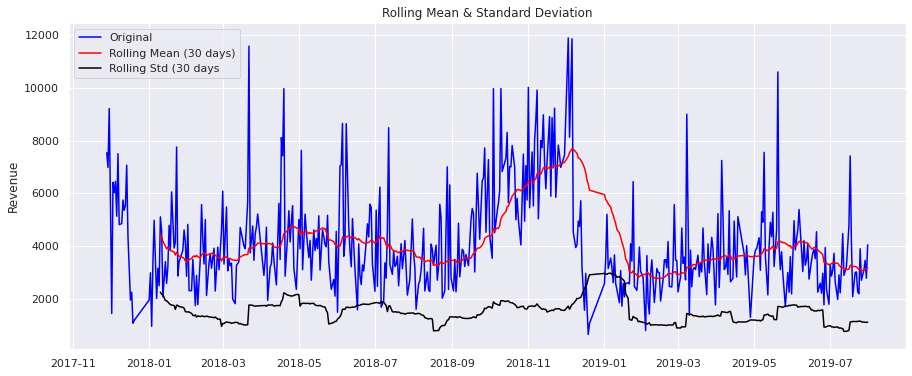

Results of Dickey-Fuller Test:
p-value = 0.0005. The series is likely stationary.
Test Statistic                  -4.261209
p-value                          0.000518
#Lags Used                       5.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64


In [42]:
test_stationarity(ts_day)

Since p-value is pretty small, but the plot seems not stationary enough. To get a stationary data,we do not need to apply log transformation, differencing

**Log-Transformed Dataset**

In [0]:
def log_shift(data, shift):
    ts_log = np.log(data)
    ts_log_diff = ts_log - ts_log.shift(shift)
    ts_log_diff = ts_log_diff.dropna()
    ts_log_diff = pd.Series(ts_log_diff.values ,index= ts_log_diff.index)
    return ts_log, ts_log_diff
## Applying ACF and PACF 
ts_log, ts_log_diff = log_shift(ts_day, 1)

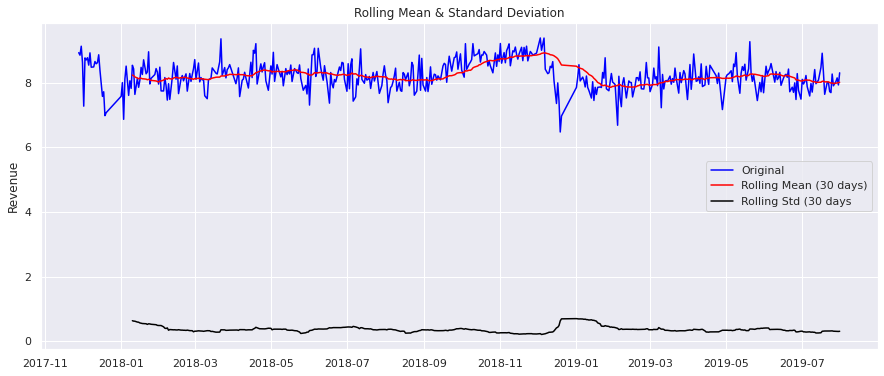

Results of Dickey-Fuller Test:
p-value = 0.0001. The series is likely stationary.
Test Statistic                  -4.815103
p-value                          0.000051
#Lags Used                       5.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64


In [44]:
test_stationarity(ts_log)

**Log tranformed differencing Dataset**

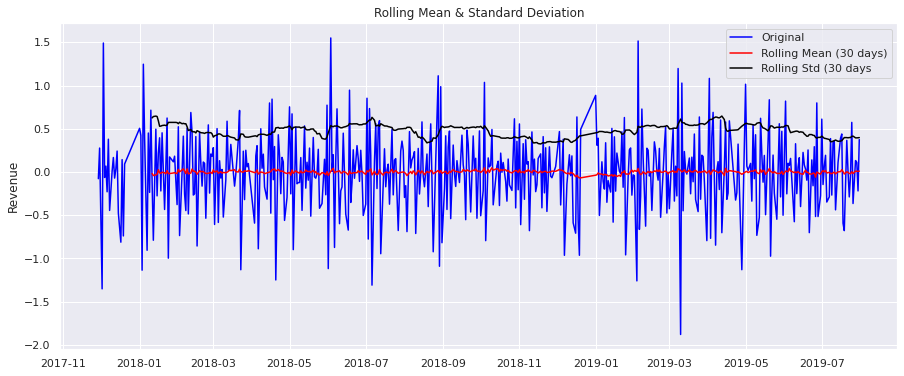

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.035194e+01
p-value                        2.523440e-18
#Lags Used                     1.000000e+01
Number of Observations Used    4.640000e+02
Critical Value (1%)           -3.444522e+00
Critical Value (5%)           -2.867789e+00
Critical Value (10%)          -2.570099e+00
dtype: float64


In [45]:
test_stationarity(ts_log_diff)

### 5.3 Time-series Forecasting

**ACF and PACF**

Applied to determine p,d,q

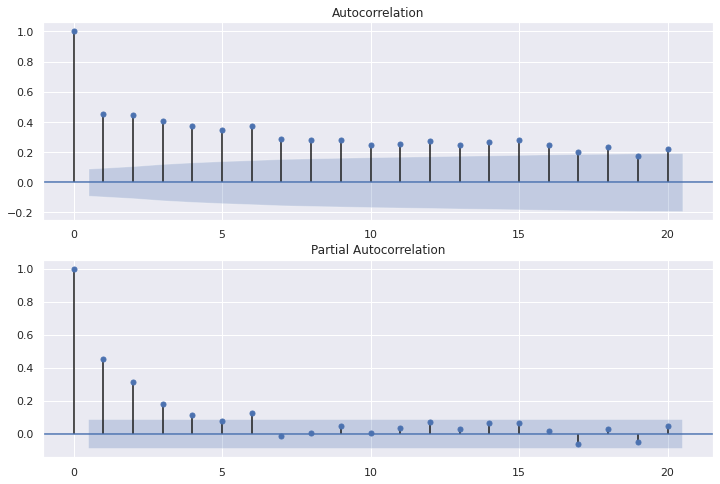

In [46]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_day, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_day, lags=20, ax=ax2)

AR model (p) could be investigated with lag length selected from the PACF. P=1

MA model (q) could be investigated with lag length selected from the ACF. q=1

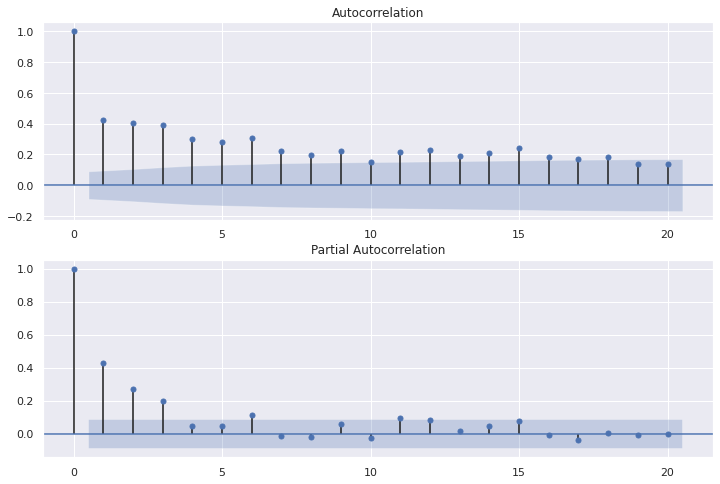

In [47]:
#ACF & PACF 
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log, lags=20, ax=ax2)

AR model (p) could be investigated with lag length selected from the PACF. P=1

MA model (q) could be investigated with lag length selected from the ACF. q=1

**Grid Search for p,d,q**

In [0]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [0]:
#Grid serach for original data
p_values = [1,2,3]
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
#evaluate_models(ts_day.values, p_values, d_values, q_values)

In [0]:
#Grid serach for Log-transformed data
p_values = [1,2,3]
d_values = [0,1]
q_values = range(0,4)
warnings.filterwarnings("ignore")
#evaluate_models(ts_log.values, p_values, d_values, q_values)


**Forecasting with original data**

In [0]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

****Forecasting with log-transformed data****

Text(0.5, 1.0, 'RMSE with log-transfored data: 1154.0766')

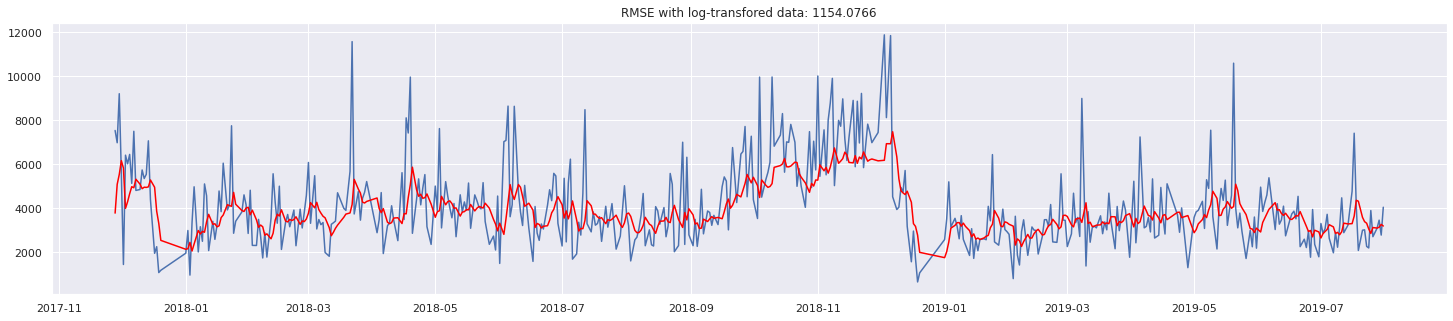

In [53]:

model = ARIMA(ts_log, order=(2,0,1))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_log = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(25,5))
plt.plot(np.exp(ts_log))
plt.plot(predictions_ARIMA, color='red')
plt.title('RMSE with log-transfored data: %.4f'% mean_absolute_error(ts_day, predictions_ARIMA))

It shows that results are much better with log-transformed data

**Model Validation with log-transformed data**

Test MAE: 969.924


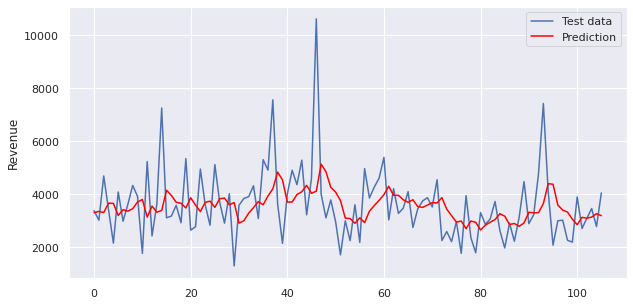

In [54]:
# split into train and test sets
X = ts_log.values
train, test = X[0:370], X[370:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(history, order=(2,0,1))
	model_fit = model.fit(disp=-1, trend='c')
	# one step forecast: The result of the forecast() 
	# function is an array containing the forecast value, 
	# the standard error of the forecast, and the confidence interval information. 
	yhat = model_fit.forecast()[0]
	# store forecast and ob
	predictions.append(yhat)
	history.append(test[t])
# evaluate forecasts
test=np.exp(test)
predictions=np.exp(predictions)
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
plt.figure(figsize=(10,5))
plt.plot(test,label='Test data')
plt.plot(predictions, color='red',label='Prediction')
plt.ylabel('Revenue')
plt.legend(loc='best')

#### 5.4 Creat functions to fetch the data from file

In [0]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """
    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']


    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    ## clean the date
    df['invoice_date']=(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)).astype('datetime64')
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


# Creat function to generate time series information
def convert_to_ts(df_orig, country=None):
    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
       
    df_time = df.groupby('invoice_date').agg({'customer_id': 'count',
                                              'invoice': 'nunique',
                                              'stream_id': 'nunique',
                                              'times_viewed':'sum', 
                                              'price':'sum'}).reset_index()
    df_time.columns=['date','purchases','unique_invoices','unique_streams','total_views','revenue']     
    df_time['year_month']=df_time.date.astype(str).str[:-3]
    return(df_time)

def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ## get original data
    print("... processing data for loading")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table=pd.pivot_table(data=df,index='country',values='price',aggfunc='sum')
    table.columns=['Total Revenue']
    table.sort_values('Total Revenue',inplace=True)
    table=table.tail(10)
    top_countries=table.index


    ## load the data
    df_time_all = {}
    df_time_all['all'] = convert_to_ts(df)
    for country in top_countries:
      df_time_all[country] = convert_to_ts(df,country=country)


    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(df_time_all)



In [0]:
# Store top 10 countries time series information
df_time_all = {}
df_time_all['all'] = convert_to_ts(df)
for country in top_countries:
    df_time_all[country] = convert_to_ts(df,country=country)

## Part 6 Time Series Forecasting with Machine Learning<a name="machine"></a>

### 6.1 Feature Enginerring

Engineer features with revenue for the previous day, previous week, previous month, previous three months and previous year

In [0]:
def engineer_features(df,training=True):
    ## extract dates
    df.reset_index(inplace=True)
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')
    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 28, 70]  #[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):
        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum()) #

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['num_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
    return(X,y,dates)

In [0]:
X,y,dates=engineer_features(df_time_day)

In [59]:
df_feature=pd.concat([X,pd.Series(y)],axis=1)
df_feature.columns.values[-1]='revenue in next 30 days'
df_feature.tail()

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,revenue in next 30 days
440,21427.37,40809.27,78000.33,203540.841,101251.99,67.916667,6865.208333,79273.020
441,21873.92,39964.27,78761.67,202746.391,101206.90,67.708333,6971.083333,74728.960
442,21380.42,42218.77,78053.24,202354.180,98954.07,66.782609,6970.478261,78497.780
443,20526.87,41778.94,78931.26,202173.720,102095.47,65.217391,6836.608696,78169.001
444,18996.36,39784.47,81145.12,199438.840,101554.02,64.500000,6735.791667,78150.191


### 6.2 Modelling

In [0]:
import time,os,re,csv,sys,uuid,joblib
from datetime import date
from collections import defaultdict
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,shuffle=True, random_state=42)
split_time=335
X_train = X[:split_time]
X_test = X[split_time:]    
y_train = y[:split_time]
y_test = y[split_time:] 

**Random Forest**

In [84]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [92]:
## train a random forest model
param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [100,150,200]
    }


pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                          ('rf', RandomForestRegressor())])
    
grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
eval_mae =  round(mean_absolute_error(y_test,y_pred))
print('MAE = %f' % eval_mae)


MAE = 8820.000000


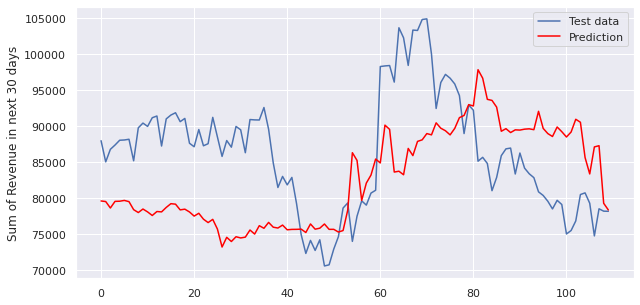

In [93]:
plt.figure(figsize=(10,5))
plt.plot(y_test,label='Test data')
plt.plot(y_pred, color='red',label='Prediction')
plt.ylabel('Sum of Revenue in next 30 days')
plt.legend(loc='best')

**Deep Learning with tensorflow**

In [0]:
split_time=335
scaler = StandardScaler()
df_feature['revenue_scale'] = scaler.fit_transform(df_feature[['revenue in next 30 days']])
series = np.array(df_feature['revenue_scale'])
x_train = series[:split_time]
x_valid = series[split_time:]

In [73]:
import tensorflow as tf
shuffle_buffer_size = 100  # < size of data size


def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size): #prepare the features and labels
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series) # create the dataset
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # 'drop_remainder=True': will only save the window with  "window_size + 1" numbers
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # flatten the data into chunks in the size of "window_size + 1"
    ds = ds.shuffle(shuffle_buffer_size) # shuffle the data for training, 'shuffle_buffer': will speed up the process 
    ds = ds.map(lambda w: (w[:-1], w[1:])) # label the features and target
    ds = ds.batch(batch_size).prefetch(1) # batch the data into size of 'batch_size'
    return ds

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(15).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(335,)


In [67]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9) # use stochastic gradient descent
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
2/2 [==============================] - 0s 35ms/step - loss: 1.8996 - mae: 2.2958 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 1.8978 - mae: 2.2942 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8941 - mae: 2.2907 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 14ms/step - loss: 1.8885 - mae: 2.2855 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8813 - mae: 2.2790 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8722 - mae: 2.2707 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8616 - mae: 2.2610 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8495 - mae: 2.2501 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 15ms/step - loss: 1.8357 - mae: 2.2376 - lr: 2.5119e-08
Epoch 10/1

Text(0, 0.5, 'Loss of that epoch')

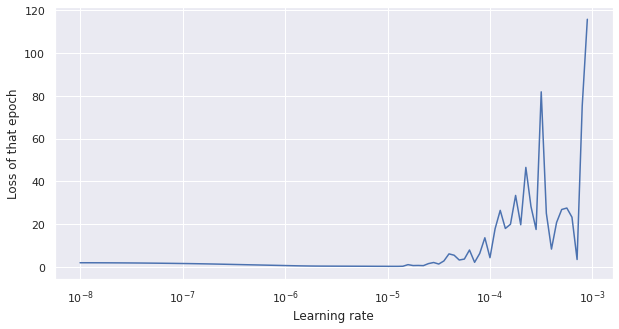

In [68]:
plt.figure(figsize=(10,5))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning rate')
plt.ylabel('Loss of that epoch')


The approaperate lr could be 1e-5

In [69]:
# Based on the figure, update the learning rate and tain again
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=15, batch_size=400, shuffle_buffer_size=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=1500)

Epoch 1/1500
1/1 [==============================] - 0s 6ms/step - loss: 0.9731 - mae: 1.3193
Epoch 2/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.8326 - mae: 1.2191
Epoch 3/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.8694 - mae: 1.2987
Epoch 4/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.6460 - mae: 0.9829
Epoch 5/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.6873 - mae: 1.0347
Epoch 6/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.5058 - mae: 0.8225
Epoch 7/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.5008 - mae: 0.8707
Epoch 8/1500
1/1 [==============================] - 0s 2ms/step - loss: 0.4242 - mae: 0.7634
Epoch 9/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.3647 - mae: 0.7104
Epoch 10/1500
1/1 [==============================] - 0s 1ms/step - loss: 0.3576 - mae: 0.7213
Epoch 11/1500
1/1 [==============================] - 0s 1ms/step - lo

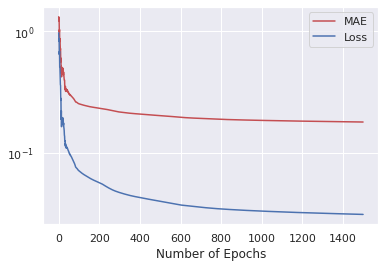

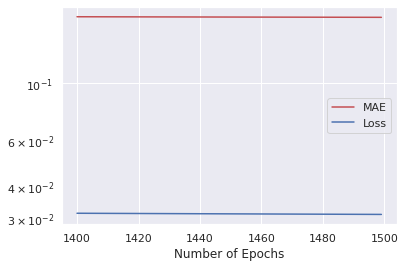

In [98]:
mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs, mae, 'r', label='MAE')
plt.plot(epochs, loss, 'b', label='Loss')
plt.yscale('log')
plt.xlabel('Number of Epochs')
plt.legend(loc='best')

plt.figure()
epochs_zoom=epochs[1400:]
mae_zoom=mae[1400:]
loss_zoom=loss[1400:]
plt.plot(epochs_zoom, mae_zoom, 'r',label='MAE')
plt.plot(epochs_zoom, loss_zoom, 'b',label='Loss')
plt.yscale('log')
plt.xlabel('Number of Epochs')
plt.legend(loc='best')

Text(0.5, 1.0, 'MAE: 3497.1750')

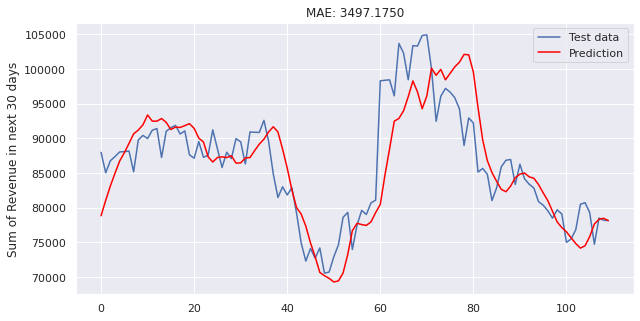

In [94]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], 15) # 'np.newaxis': reshape the input dimension
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

#inverse the predictions
x_valid_ori=scaler.inverse_transform(x_valid)
rnn_forecast_ori=scaler.inverse_transform(rnn_forecast)


plt.figure(figsize=(10, 5))
plt.plot(x_valid_ori,label='Test data')
plt.plot(rnn_forecast_ori,color='red',label='Prediction')
plt.legend(loc='best')
plt.ylabel('Sum of Revenue in next 30 days')
plt.title('MAE: %.4f'% tf.keras.metrics.mean_absolute_error(x_valid_ori, rnn_forecast_ori).numpy())
